In [1]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x)
train_y = Variable(torch.sin(((train_x.data[:, 0] + train_x.data[:, 1]) * (2 * math.pi))))

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=20,
                                                    grid_bounds=[(0, 1), (0, 1)])
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)


likelihood = GaussianLikelihood()
model = GPRegressionModel(train_x.data, train_y.data, likelihood)

In [4]:
# Optimize the model
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0

def train():
    for i in range(30):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()
%time train()

Iter 1/30 - Loss: 1.081
Iter 2/30 - Loss: 0.999
Iter 3/30 - Loss: 0.927
Iter 4/30 - Loss: 0.845
Iter 5/30 - Loss: 0.774
Iter 6/30 - Loss: 0.708
Iter 7/30 - Loss: 0.636
Iter 8/30 - Loss: 0.562
Iter 9/30 - Loss: 0.476
Iter 10/30 - Loss: 0.385
Iter 11/30 - Loss: 0.282
Iter 12/30 - Loss: 0.164
Iter 13/30 - Loss: 0.027
Iter 14/30 - Loss: -0.102
Iter 15/30 - Loss: -0.243
Iter 16/30 - Loss: -0.376
Iter 17/30 - Loss: -0.509
Iter 18/30 - Loss: -0.628
Iter 19/30 - Loss: -0.750
Iter 20/30 - Loss: -0.874
Iter 21/30 - Loss: -0.978
Iter 22/30 - Loss: -1.091
Iter 23/30 - Loss: -1.203
Iter 24/30 - Loss: -1.294
Iter 25/30 - Loss: -1.401
Iter 26/30 - Loss: -1.502
Iter 27/30 - Loss: -1.595
Iter 28/30 - Loss: -1.666
Iter 29/30 - Loss: -1.771
Iter 30/30 - Loss: -1.867
CPU times: user 10.1 s, sys: 40 ms, total: 10.1 s
Wall time: 9.83 s


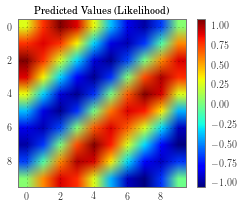

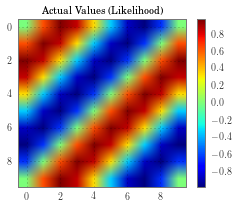

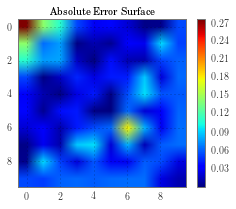

In [5]:
model.eval()
likelihood.eval()

n = 10
test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)

observed_pred = likelihood(model(test_x))
pred_labels = observed_pred.mean().view(n, n).data.numpy()

test_y_actual = torch.sin(((test_x.data[:, 0] + test_x.data[:, 1]) * (2 * math.pi))).numpy().reshape(n, n)
delta_y = numpy.absolute(pred_labels - test_y_actual)

def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')